# Optimal Transport Project

*Authors : Romain Avouac, Slimane Thabet*

In [0]:
from time import time
from multiprocessing import cpu_count
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image, resize, to_tensor
from torchvision.transforms.functional import normalize
import imageio

In [0]:
# GPU configuration
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

In [0]:
class DoubleBatchDataset(data.Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        return self.dataset1.shape[0]

    def __getitem__(self, index):
        return self.dataset1[index], self.dataset2[index]

In [0]:
def load_mnist(batch_size=128, img_size=28, double_batch=False):
    """Download, preprocess and load MNIST data."""
    mnist = datasets.MNIST('data', train=True, download=True).data
    # Perform transformation directly on raw data rather than in the DataLoader
    # => avoids overhead of performing transforms at each batch call 
    # => much faster epochs.
    pics = []
    for pic in mnist:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size) # Resize image if needed
        pic = to_tensor(pic) # Tensor conversion normalizes in [0,1]
        pic = normalize(pic, [0.5], [0.5]) # Normalize values in [-1,1]
        pics.append(pic)

    mnist = torch.stack(pics)

    if double_batch:
        mnist = DoubleBatchDataset(mnist, mnist)

    return torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

## Vanilla GAN

In [0]:
class GANGenerator(nn.Module):
    def __init__(self, input_size, d, output_shape):
        super(GANGenerator, self).__init__()

        self.map1 = nn.Linear(input_size, d)
        self.map2 = nn.Linear(self.map1.out_features, d*2)
        self.map3 = nn.Linear(self.map2.out_features, d*4)
        self.map4 = nn.Linear(self.map3.out_features, 
                              output_shape[0] * output_shape[1] * output_shape[2])

        self.act = nn.LeakyReLU(negative_slope=0.2)
        self.output_shape = output_shape

    def forward(self, x):
        x = self.act(self.map1(x))
        x = self.act(self.map2(x))
        x = self.act(self.map3(x))
        x = torch.tanh(self.map4(x))
        
        return x.view((-1,)+self.output_shape)

In [0]:
class GANCritic(nn.Module):
    def __init__(self, input_size, d):
        super(GANCritic, self).__init__()

        self.map1 = nn.Linear(input_size, d)
        self.map2 = nn.Linear(self.map1.out_features, d//2)
        self.map3 = nn.Linear(self.map2.out_features, d//4)
        self.map4 = nn.Linear(self.map3.out_features, 1)

        self.act = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.act(self.map1(x))
        x = F.dropout(x, 0.3)
        x = self.act(self.map2(x))
        x = F.dropout(x, 0.3)
        x = self.act(self.map3(x))
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.map4(x))

        return x

In [0]:
class GAN():
    
    def __init__(self, dataloader, generator, critic, lr=0.0001):

        self.dataloader = dataloader

        # default parameters for mnist 
        self.img_channels = dataloader.dataset[0].shape[0]
        self.img_rows = dataloader.dataset[0].shape[1]
        self.img_cols = dataloader.dataset[0].shape[2]
        self.img_shape = (self.img_channels, self.img_rows, self.img_cols)
        self.z_dim = z_dim
        self.lr = lr

        self.generator = generator.to(device)
        self.critic = critic.to(device)

        
    def sample_data(self, n_sample):
        z_random = np.random.randn(n_sample, self.z_dim)
        z_random = torch.FloatTensor(z_random).to(device)
        samples = self.generator(z_random)
        samples = samples.detach().cpu().numpy()
        return samples
        
    def train(self, epochs=100, print_interval=10, save_generator_path=None):
        
        criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
        d_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr, betas=(0.5, 0.999))
        g_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.5, 0.999))
        d_steps = 1
        g_steps = 1

        t = time()
        
        for epoch in range(epochs):
            
            for batch in self.dataloader:
                batch = batch.type(torch.FloatTensor).to(device)

                for d_index in range(d_steps):
                    # 1. Train D on real+fake
                    self.critic.zero_grad()

                    #  1A: Train D on real
                    d_real_data = Variable(batch.to(device))
                    d_real_decision = self.critic(d_real_data)
                    y_real = Variable(torch.ones(d_real_decision.shape).to(device))
                    d_real_error = criterion(d_real_decision, y_real)
        
                    #  1B: Train D on fake
                    d_gen_input = torch.randn((batch.shape[0], self.z_dim))
                    d_gen_input = Variable(d_gen_input.to(device))
                    d_fake_data = self.generator(d_gen_input).detach()  # detach to avoid training G on these labels
                    d_fake_decision = self.critic(d_fake_data)
                    y_fake = Variable(torch.zeros(d_real_decision.shape).to(device))
                    d_fake_error = criterion(d_fake_decision, y_fake) 

                    # Backward propagation on the sum of the two losses
                    d_train_loss = d_real_error + d_fake_error
                    d_train_loss.backward()
                    d_optimizer.step() # Only optimizes D's parameters
        
                for g_index in range(g_steps):
                    # 2. Train G on D's response (but DO NOT train D on these labels)
                    self.generator.zero_grad()
        
                    gen_input = torch.randn((batch.shape[0], self.z_dim))
                    gen_input = Variable(gen_input.to(device))
                    g_fake_data = self.generator(gen_input)
                    dg_fake_decision = self.critic(g_fake_data)
                    y_ones = Variable(torch.ones(dg_fake_decision.shape).to(device))
                    g_error = criterion(dg_fake_decision, y_ones)   # Train G to pretend it's genuine
        
                    g_error.backward()
                    g_optimizer.step()  # Only optimizes G's parameters
                    
    
            if (epoch > 0 and epoch % print_interval == 0) or epoch+1 == epochs:
                de = d_train_loss.detach().cpu().numpy()
                ge = g_error.detach().cpu().numpy()
                print("Epoch %s: C_loss =  %s ;  G_loss = %s;  time = %s" %
                      (epoch, de, ge, time()-t))
                
            # if epoch % 1 == 0:
            #     samples = self.sample_data(3)*0.5 + 0.5
            #     for img in samples:
            #         plt.figure()
            #         plt.imshow(img[0,:,:], cmap='gray')
            #         plt.show()

        if save_generator_path is not None:
            torch.save(self.generator.state_dict(), save_generator_path)


In [0]:
# Vanilla GAN parameters
img_size = 28
z_dim = 100
G_dim_init = 128
C_dim_init = 1024

lr = 0.0002
batch_size = 128
n_epochs = 100

save_generator_path = 'vanilla_gan_gen.pt'

In [0]:
# Get MNIST data as Torch dataloader
mnist_dataloader = load_mnist(batch_size=batch_size, img_size=img_size)
img_shape = mnist_dataloader.dataset[0].shape
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

In [10]:
TRAIN_MODE = False

if TRAIN_MODE:
    # Train GAN and save generator weights
    gan_generator = GANGenerator(z_dim, G_dim_init, img_shape)
    gan_critic = GANCritic(n_pixels, C_dim_init)
    gan = GAN(mnist_dataloader, gan_generator, gan_critic, lr=lr)
    gan.train(n_epochs, save_generator_path=save_generator_path,
              print_interval=10) # Change `save_generator_path` to None to prevent saving weights
else:
    # Load previously trained generator weights
    gan_generator = GANGenerator(z_dim, G_dim_init, img_shape)
    gan_generator.load_state_dict(torch.load(save_generator_path))
    gan_critic = GANCritic(n_pixels, C_dim_init) # Not used
    gan = GAN(mnist_dataloader, gan_generator, gan_critic, lr=lr)

NameError: ignored

In [0]:
# Plot some generated images as a GIF
samples = gan.sample_data(500)*0.5 + 0.5
samples = samples * 256
samples = samples.astype(np.uint8)
samples = np.squeeze(samples, 1)

gif_path = 'vanilla_gan.gif'
imageio.mimwrite(gif_path, samples, fps=5)
gifPath = Path(gif_path)
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png', width=200, height=200)

## DC-GAN

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [0]:
class DCGANGenerator(nn.Module):
    def __init__(self, z_dim, d):
        super(DCGANGenerator, self).__init__()

        self.z_dim = z_dim

        self.deconv1 = nn.ConvTranspose2d(z_dim, d, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d)
        self.deconv2 = nn.ConvTranspose2d(d, d//2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d//2)
        self.deconv3 = nn.ConvTranspose2d(d//2, d//4, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d//4)
        self.deconv4 = nn.ConvTranspose2d(d//4, d//8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d//8)
        self.deconv5 = nn.ConvTranspose2d(d//8, 1, 4, 2, 1)

        self.activ = nn.ReLU()

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        x = x.view(-1, self.z_dim, 1, 1)
        x = self.activ(self.deconv1_bn(self.deconv1(x)))
        x = self.activ(self.deconv2_bn(self.deconv2(x)))
        x = self.activ(self.deconv3_bn(self.deconv3(x)))
        x = self.activ(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x)) # Output shape : 
        return x

In [0]:
class DCGANCritic(nn.Module):
    def __init__(self, d):
        super(DCGANCritic, self).__init__()

        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

        self.activ = nn.LeakyReLU(negative_slope=0.2)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2_bn(self.conv2(x)))
        x = self.activ(self.conv3_bn(self.conv3(x)))
        x = self.activ(self.conv4_bn(self.conv4(x)))
        x = torch.sigmoid(self.conv5(x))

        return x.view((-1, 1)) # (batch_size, 1)

In [0]:
# DC-GAN parameters
img_size = 64
z_dim = 100
G_dim_init = 512 # 1024 or 512
C_dim_init = G_dim_init // 8

lr = 0.0002
batch_size = 128
n_epochs = 20

path_weights_dcgan = 'dc_gan_gen.pt'

In [0]:
# Get MNIST data as Torch dataloader
mnist_dataloader = load_mnist(batch_size=batch_size, img_size=img_size)
img_shape = mnist_dataloader.dataset[0].shape

In [0]:
TRAIN_MODE = True

if TRAIN_MODE:
    # Train GAN and save generator weights
    dcgan_generator = DCGANGenerator(z_dim, G_dim_init)
    dcgan_generator.weight_init(mean=0.0, std=0.02)
    dcgan_critic = DCGANCritic(C_dim_init)
    dcgan_critic.weight_init(mean=0.0, std=0.02)
    dcgan = GAN(mnist_dataloader, dcgan_generator, dcgan_critic, lr=lr)
    dcgan.train(n_epochs, save_generator_path=path_weights_dcgan,
                print_interval=5) # Change `save_generator_path` to None to prevent saving weights
else:
    # Load previously trained generator weights
    dcgan_generator = DCGANGenerator(z_dim, G_dim_init)
    dcgan_generator.load_state_dict(torch.load(path_weights_dcgan))
    dcgan_critic = DCGANCritic(C_dim_init) # Not used
    dcgan = GAN(mnist_dataloader, dcgan_generator, dcgan_critic, lr=lr)

In [0]:
# Plot some generated images as a GIF
samples = dcgan.sample_data(500)*0.5 + 0.5
samples = samples * 256
samples = samples.astype(np.uint8)
samples = np.squeeze(samples, 1)

gif_path = 'dc_gan.gif'
imageio.mimwrite(gif_path, samples, fps=5)
gifPath = Path(gif_path)
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png', width=200, height=200)

## OT-GAN

In [0]:
class OTGANGenerator(nn.Module):
    def __init__(self, input_size, kernel_size=5):
        super(OTGANGenerator, self).__init__()

        self.linear = nn.Linear(input_size, 2*512*8*8)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        conv_padding_size = (kernel_size - 1) // 2

        self.conv1 = nn.Conv2d(512, 2*256, kernel_size, padding=conv_padding_size)
        self.conv2 = nn.Conv2d(256, 2*128, kernel_size, padding=conv_padding_size)
        self.conv3 = nn.Conv2d(128, 1, kernel_size, padding=conv_padding_size)

        self.activ_out = nn.Tanh()

    def forward(self, x):

        x = self.linear(x)
        # GLU activation function
        x, l = torch.split(x, x.shape[1]//2, 1)
        x *= torch.sigmoid(l)
        x = x.view((x.shape[0], 512, 8, 8))

        x = self.upsample(x)
        x = self.conv1(x)
        x, l = torch.split(x, x.shape[1]//2, 1)
        x *= torch.sigmoid(l)

        x = self.upsample(x)
        x = self.conv2(x)
        x, l = torch.split(x, x.shape[1]//2, 1)
        x *= torch.sigmoid(l)

        x = self.activ_out(self.conv3(x))

        return x

In [0]:
class OTGANCritic(nn.Module):
    def __init__(self, kernel_size=5):
        super(OTGANCritic, self).__init__()

        conv1_channels = 64
        conv_padding_size = (kernel_size - 1) // 2


        self.conv1 = nn.Conv2d(1, conv1_channels, kernel_size, padding=conv_padding_size)
        self.conv2 = nn.Conv2d(conv1_channels*2, conv1_channels*2, kernel_size, 
                               stride=2, padding=conv_padding_size)
        self.conv3 = nn.Conv2d(conv1_channels*4, conv1_channels*4, kernel_size, 
                               stride=2, padding=conv_padding_size)

    def forward(self, x):
        x = self.conv1(x)
        # CReLU : https://github.com/pytorch/pytorch/issues/1327
        x = torch.cat((F.relu(x), F.relu(-x)), 1)
        x = self.conv2(x)
        x = torch.cat((F.relu(x), F.relu(-x)), 1)
        x = self.conv3(x)
        x = torch.cat((F.relu(x), F.relu(-x)), 1)
        x = nn.Flatten()(x)
        x = F.normalize(x, dim=1, p=2)
        return x

In [0]:
class OTGAN():
    
    def __init__(self, dataloader, generator, critic, g_to_c_ratio=3, lr=0.0003):

        self.dataloader = dataloader

        # default parameters for mnist 
        self.img_channels = dataloader.dataset[0][0].shape[0]
        self.img_rows = dataloader.dataset[0][0].shape[1]
        self.img_cols = dataloader.dataset[0][0].shape[2]
        self.img_shape = (self.img_channels, self.img_rows, self.img_cols)
        self.z_dim = z_dim
        self.lr = lr
        self.g_to_c_ratio = g_to_c_ratio

        self.generator = generator.to(device)
        self.critic = critic.to(device)


    def uniform_m1_1(self, size):
        return -2 * torch.rand(size) + 1

        
    def sample_data(self, n_sample):
        z_random = self.uniform_m1_1((n_sample, self.z_dim)).to(device)
        samples = self.generator(z_random)
        samples = samples.detach().cpu().numpy()
        return samples


    def cost(self, batch_1, batch_2):
        dot = batch_1 @ batch_2.t()
        norm1 = torch.norm(batch_1, 2, 1)
        norm2 = torch.norm(batch_2, 2, 1)
        div = torch.div(dot, norm1)
        cos_sim = torch.div(div, torch.unsqueeze(norm2, 0))
        return 1 - cos_sim

    def sinkhorn(self, a, b, C, reg=1, max_iters=100):
        
        u = torch.ones_like(a).to(device)
        v = torch.ones_like(b).to(device)

        with torch.no_grad():
            # No backprop through sinkhorn algorithm
            K = torch.exp(-C/reg)
            for i in range(max_iters):
                u = a / (torch.matmul(K,v) + 1e-8)
                v = b / (torch.matmul(K.T,u) + 1e-8)

        return torch.matmul(torch.diag(u), 
                            torch.matmul(K, torch.diag(v)))

        
    def train(self, epochs=100, print_interval=10, save_every=1):
        
        c_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr, 
                                 betas=(0.5, 0.999))
        g_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr, 
                                 betas=(0.5, 0.999))
        
        for epoch in range(epochs):
            
            t=time()
            loss_to_display = []
            
            for i, (real_1, real_2) in enumerate(self.dataloader):
                
                batch_size = real_1.shape[0]

                self.critic.zero_grad()
                self.generator.zero_grad()
    
                real_1 = real_1.type(torch.FloatTensor).to(device)
                real_2 = real_2.type(torch.FloatTensor).to(device)
                
                z1 = self.uniform_m1_1((batch_size, self.z_dim)).to(device)
                fake_1 = self.generator(z1)
                z2 = self.uniform_m1_1((batch_size, self.z_dim)).to(device)
                fake_2 = self.generator(z2)
                
                critic_real_1 = self.critic(real_1)
                critic_real_2 = self.critic(real_2)
                critic_fake_1 = self.critic(fake_1)
                critic_fake_2 = self.critic(fake_2)

                # Computing all matrices of costs

                costs = torch.zeros((4, 4, batch_size, batch_size)).to(device)

                costs[0,1] = self.cost(critic_real_1, critic_real_2)
                costs[0,2] = self.cost(critic_real_1, critic_fake_1)
                costs[0,3] = self.cost(critic_real_1, critic_fake_2)
                costs[1,2] = self.cost(critic_real_2, critic_fake_1)
                costs[1,3] = self.cost(critic_real_2, critic_fake_2)
                costs[2,3] = self.cost(critic_fake_1, critic_fake_2)

                # Computing optimal plans for all costs

                a = (torch.ones(batch_size) / batch_size).to(device)
                b = (torch.ones(batch_size) / batch_size).to(device)
                
                plans = torch.zeros((4,4, batch_size, batch_size)).to(device)
                plans[0,1] = self.sinkhorn(a, b, costs[0,1])
                plans[0,2] = self.sinkhorn(a, b, costs[0,2])
                plans[0,3] = self.sinkhorn(a, b, costs[0,3])
                plans[1,2] = self.sinkhorn(a, b, costs[1,2])
                plans[1,3] = self.sinkhorn(a, b, costs[1,3])
                plans[2,3] = self.sinkhorn(a, b, costs[2,3]) 

                # Computing losses
                
                losses = torch.zeros((4,4)).to(device)
                
                losses[0,1] = torch.sum(plans[0,1] * costs[0,1])
                losses[0,2] = torch.sum(plans[0,2] * costs[0,2])
                losses[0,3] = torch.sum(plans[0,3] * costs[0,3])
                losses[1,2] = torch.sum(plans[1,2] * costs[1,2])
                losses[1,3] = torch.sum(plans[1,3] * costs[1,3])
                losses[2,3] = torch.sum(plans[2,3] * costs[2,3])    
                
                loss = (losses[0,2] + losses[0,3] + losses[1,2] + losses[1,3] -
                        2 * losses[0,1] - 2 * losses[2,3])
                                
                loss.backward()
                g_optimizer.step()

                if i+1 % self.g_to_c_ratio == 0:
                    # Update critic once every `g_to_c_ratio` updates
                    c_optimizer.step()
                else:
                    g_optimizer.step()

                print(i)

    
            if epoch % print_interval == 0 or epoch+1 == epochs:
                train_loss = loss.detach().cpu().numpy()
                print("Epoch %s: loss = %s;  time = %s" %
                      (epoch, train_loss, time()-t))
                
            if epoch % print_interval == 0 or epoch+1 == epochs:
                samples = self.sample_data(3)*0.5 + 0.5
                for img in samples:
                    plt.figure()
                    plt.imshow(img[0,:,:], cmap='gray')
                    plt.show()

            if save_every:
                torch.save(self.generator.state_dict(), 'ot_gan_gen.pt')
                torch.save(self.critic.state_dict(), 'ot_gan_critic.pt')


In [0]:
# Get MNIST data as Torch dataloader
img_size = 32
batch_size = 512

mnist_dataloader = load_mnist(batch_size=batch_size, img_size=img_size, 
                              double_batch=True)

In [0]:
# OT-GAN parameters
z_dim = 100
n_epochs = 10

path_weights_otgan = 'ot_gan_gen.pt', 'ot_gan_critic.pt'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
Epoch 0: loss = 0.003790915;  time = 1604.1197304725647


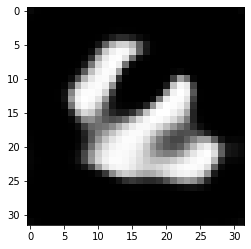

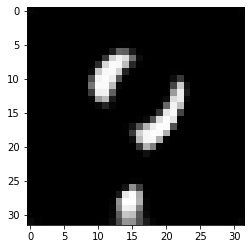

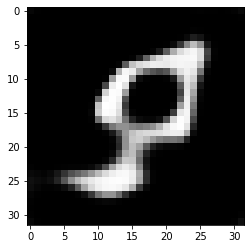

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


In [0]:
TRAIN_MODE = True
RESUME_TRAINING = False

if TRAIN_MODE:
    # Train GAN and save generator weights
    otgan_generator = OTGANGenerator(input_size=z_dim)
    otgan_critic = OTGANCritic()
    otgan = OTGAN(mnist_dataloader, otgan_generator, otgan_critic)
    otgan.train(n_epochs, save_every=1)
else:
    # Load previously trained model weights
    otgan_generator = OTGANGenerator(input_size=z_dim)
    otgan_generator.load_state_dict(torch.load(path_weights_otgan[0]))
    otgan_critic = OTGANCritic()
    otgan_critic.load_state_dict(torch.load(path_weights_otgan[1]))
    otgan = OTGAN(mnist_dataloader, otgan_generator, otgan_critic, lr=lr)

    if RESUME_TRAINING:
        otgan.train(n_epochs, save_every=1)

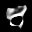

In [22]:
# Plot some generated images as a GIF
samples = otgan.sample_data(100)*0.5 + 0.5
samples = samples * 256
samples = samples.astype(np.uint8)
samples = np.squeeze(samples, 1)

gif_path = 'otgan_gan.gif'
imageio.mimwrite(gif_path, samples, fps=5)
gifPath = Path(gif_path)
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png', width=200, height=200)